In [1]:
'''
Подключение всех нужных библиотек и функций
'''

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from IPython.display import display

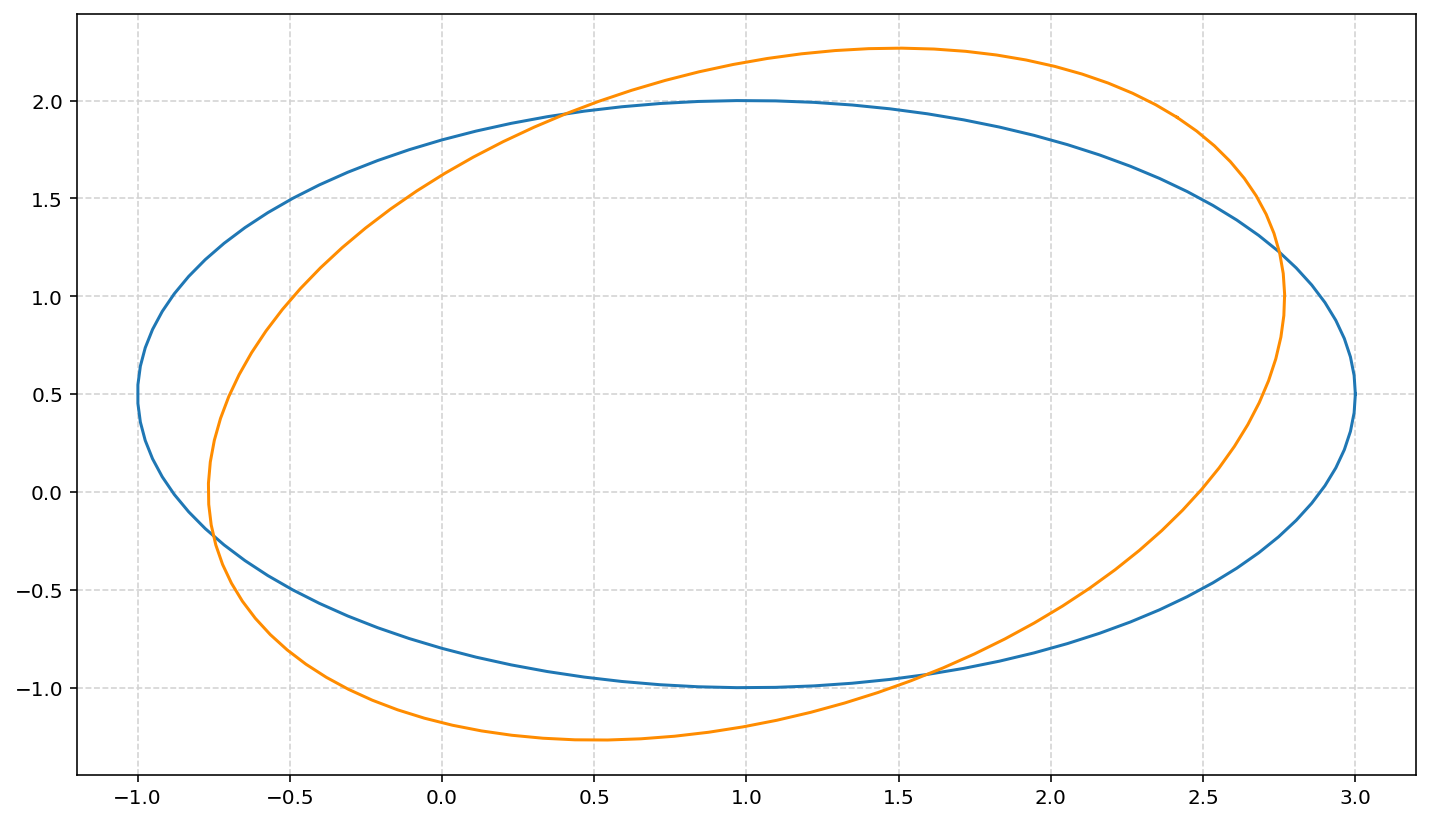

In [3]:
# Начальное условие для генератора случайных чисел
np.random.seed(42)



'''
Процедура анализа данных
'''
def analyze(df, iris=False, model=False, projection_2d=False):
    # Первые строки таблицы
    def print_table_head(df):
        if model == True:
            X = extract_X(df)
            df = pd.DataFrame(data=X, columns=df.columns[:-1])
        
        print('Первые ' + str(df.head().shape[0]) + ' строк таблицы:')
        display(df.head())
        print()

    # Вывод матрицы ковариаций
    def print_cov_matrix(X):
        # Вычисление матрицы ковариаций признаков
        def cov_matrix(X):
            return np.cov(X.T)

        print('Выборочная матрица ковариаций:')
        print(cov_matrix(X))
        print()

    # Извлечение матрицы признаков из датафрейма
    def extract_X(df):
        features = df.columns[:-1]
        X = df.loc[:, features].values

        return X

    # Построение графика
    def graph(df, title, targets):
        fig = plt.figure()
        
        if projection_2d == True:
            ax = fig.add_subplot(1, 1, 1)
        else:
            ax = fig.add_subplot(1, 1, 1, projection='3d')
        
        ax.set_xlabel(df.columns[0])
        ax.set_ylabel(df.columns[1])
        
        if projection_2d == False:
            ax.set_zlabel(df.columns[2])
        
        ax.set_title(title)
        colors = ['r', 'g', 'b']

        for i in range(len(targets)):
            indicesToKeep = df[df.columns[-1]] == targets[i]

            if projection_2d == True:
                ax.scatter(df.loc[indicesToKeep, df.columns[0]],
                       df.loc[indicesToKeep, df.columns[1]],
                       c=colors[i])
            else:
                ax.scatter(df.loc[indicesToKeep, df.columns[0]],
                       df.loc[indicesToKeep, df.columns[1]],
                       df.loc[indicesToKeep, df.columns[2]],
                       c=colors[i])
                
        if model == False:
            if iris == False:
                targets = [
                    str(int(float(target))) + '-й класс' for target in targets
                ]

            ax.legend(targets)
        
        ax.grid()

    # Метод PCA
    def get_PCA_df(df, X):
        X = StandardScaler().fit_transform(X)
        
        if projection_2d == True:
            pca = PCA(n_components=2)
        else:
            pca = PCA(n_components=3)
        
        PCA_X = pca.fit_transform(X)
        
        if projection_2d == True:
            cols = ['1-я главная компонента', '2-я главная компонента']
        else:
            cols = ['1-я главная компонента', '2-я главная компонента', '3-я главная компонента']
        
        principalDf = pd.DataFrame(
            data=PCA_X,
            columns=cols)
        class_name = df.columns[-1]
        finalDf = pd.concat([principalDf, df[class_name]], axis=1)

        return finalDf

    print('*** Исходные данные ***\n\n')

    X = extract_X(df)
    print_table_head(df)
    print_cov_matrix(X)

    print('\n*** Данные после метода PCA ***\n\n')

    PCA_df = get_PCA_df(df, X)
    PCA_X = extract_X(PCA_df)
    print_table_head(PCA_df)
    print_cov_matrix(PCA_X)

    class_name = df.columns[-1]
    classes = np.unique(df.loc[:, class_name].values)
    
    graph(PCA_df, 'График PCA-данных', classes)

*** Исходные данные ***


Первые 5 строк таблицы:


<ipython-input-4-caf4d9805401>:11: RuntimeWarning: covariance is not positive-semidefinite.
  return np.random.multivariate_normal(mean=mean, cov=sigma, size=size)


,1-ый признак,2-ой признак,3-ий признак,4-ый признак
0,-0.614131,0.200560,1.015251,1.829942
1,0.000016,1.242109,2.484203,3.726296
2,0.978808,1.941024,2.903241,3.865458
3,-2.084482,-0.220456,1.643571,3.507598
4,1.283508,2.644657,4.005806,5.366955



Выборочная матрица ковариаций:
[[1.81204585 1.76466099 1.71727612 1.66989125]
 [1.76466099 2.24349783 2.72233468 3.20117153]
 [1.71727612 2.72233468 3.72739325 4.73245181]
 [1.66989125 3.20117153 4.73245181 6.26373208]]


*** Данные после метода PCA ***


Первые 5 строк таблицы:


,1-я главная компонента,2-я главная компонента
0,-0.936433,-0.054295
1,0.411214,-0.228703
2,1.122467,0.311252
3,-1.064819,-1.400659
4,2.070431,0.065672



Выборочная матрица ковариаций:
[[ 3.42575489e+00 -3.57405130e-16]
 [-3.57405130e-16  5.78249114e-01]]



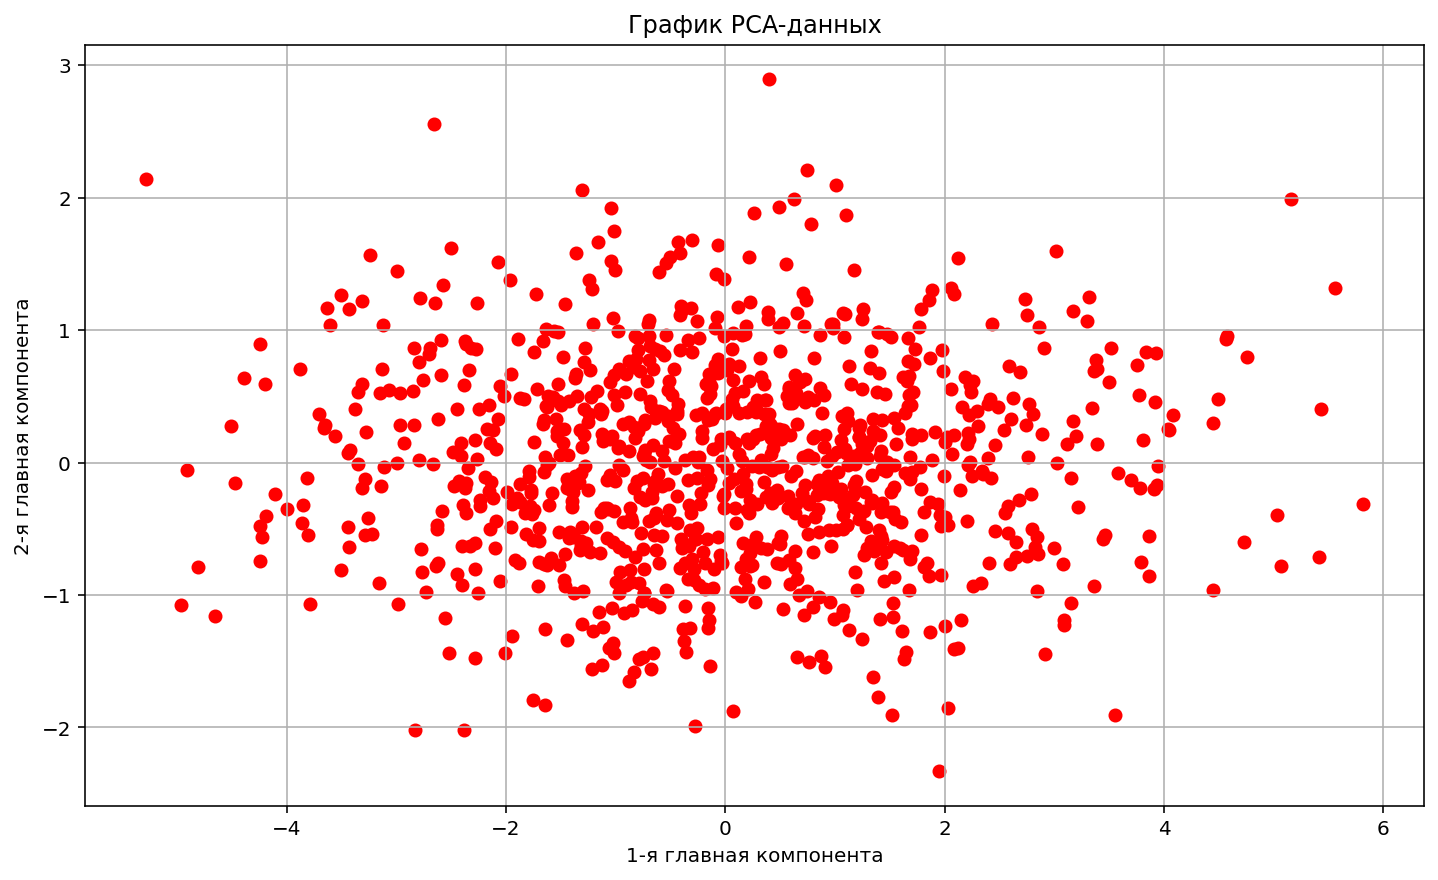

In [4]:
'''
Модельные данные (2 главные компоненты)
'''



'''
Генерация случайной выборки из многомерного нормального распределения
'''
def gen_N(mean, sigma, size):
    return np.random.multivariate_normal(mean=mean, cov=sigma, size=size)



sigma = np.array([
        [0, 1, 2, 3],
        [1, 2, 3, 4],
        [2, 3, 4, 5],
        [3, 4, 5, 6]
    ])
mu = np.array([0, 1, 2, 3])
n = 1000
X = gen_N(mu, sigma, n)
y = np.full((n, 1), 1)
Xy = np.append(X, y, axis = 1)

df = pd.DataFrame(
    data=Xy,
    columns=['1-ый признак', '2-ой признак', '3-ий признак', '4-ый признак', 'Класс'])
analyze(df, model=True, projection_2d=True)

*** Исходные данные ***


Первые 5 строк таблицы:


,1-ый признак,2-ой признак,3-ий признак,4-ый признак
0,-0.614131,0.200560,1.015251,1.829942
1,0.000016,1.242109,2.484203,3.726296
2,0.978808,1.941024,2.903241,3.865458
3,-2.084482,-0.220456,1.643571,3.507598
4,1.283508,2.644657,4.005806,5.366955



Выборочная матрица ковариаций:
[[1.81204585 1.76466099 1.71727612 1.66989125]
 [1.76466099 2.24349783 2.72233468 3.20117153]
 [1.71727612 2.72233468 3.72739325 4.73245181]
 [1.66989125 3.20117153 4.73245181 6.26373208]]


*** Данные после метода PCA ***


Первые 5 строк таблицы:


,1-я главная компонента,2-я главная компонента,3-я главная компонента
0,-0.936433,-0.054295,2.768920e-09
1,0.411214,-0.228703,-1.322753e-08
2,1.122467,0.311252,1.775848e-09
3,-1.064819,-1.400659,1.667514e-08
4,2.070431,0.065672,5.650787e-10



Выборочная матрица ковариаций:
[[ 3.42575489e+00 -1.58254013e-16 -3.70947862e-25]
 [-1.58254013e-16  5.78249114e-01 -9.27369656e-26]
 [-3.70947862e-25 -9.27369656e-26  1.83671927e-16]]



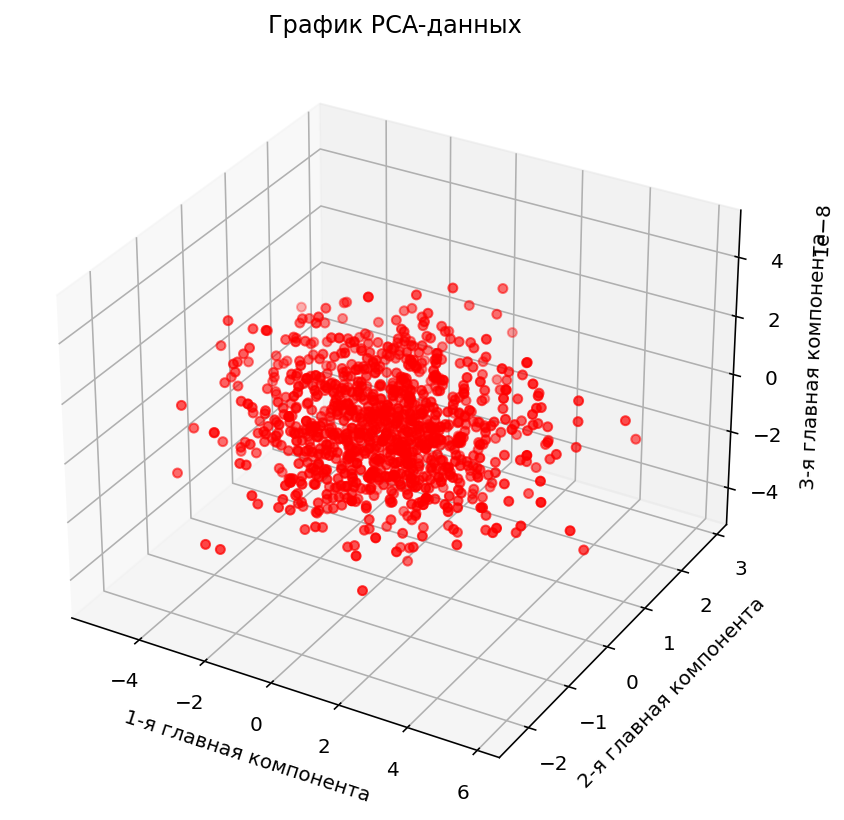

In [5]:
'''
Модельные данные (3 главные компоненты)
'''



analyze(df, model=True)

*** Исходные данные ***


Первые 5 строк таблицы:


,Длина чашелистика,Ширина чашелистика,Длина лепестка,Ширина лепестка,Вид
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa



Выборочная матрица ковариаций:
[[ 0.68569351 -0.03926846  1.27368233  0.5169038 ]
 [-0.03926846  0.18800403 -0.32171275 -0.11798121]
 [ 1.27368233 -0.32171275  3.11317942  1.29638747]
 [ 0.5169038  -0.11798121  1.29638747  0.58241432]]


*** Данные после метода PCA ***


Первые 5 строк таблицы:


,1-я главная компонента,2-я главная компонента,3-я главная компонента,Вид
0,-2.264542,0.505704,-0.121943,Iris-setosa
1,-2.086426,-0.655405,-0.227251,Iris-setosa
2,-2.367950,-0.318477,0.051480,Iris-setosa
3,-2.304197,-0.575368,0.098860,Iris-setosa
4,-2.388777,0.674767,0.021428,Iris-setosa



Выборочная матрица ковариаций:
[[ 2.93035378e+00  8.01141496e-17 -6.19953617e-17]
 [ 8.01141496e-17  9.27403622e-01 -5.14523030e-18]
 [-6.19953617e-17 -5.14523030e-18  1.48342226e-01]]



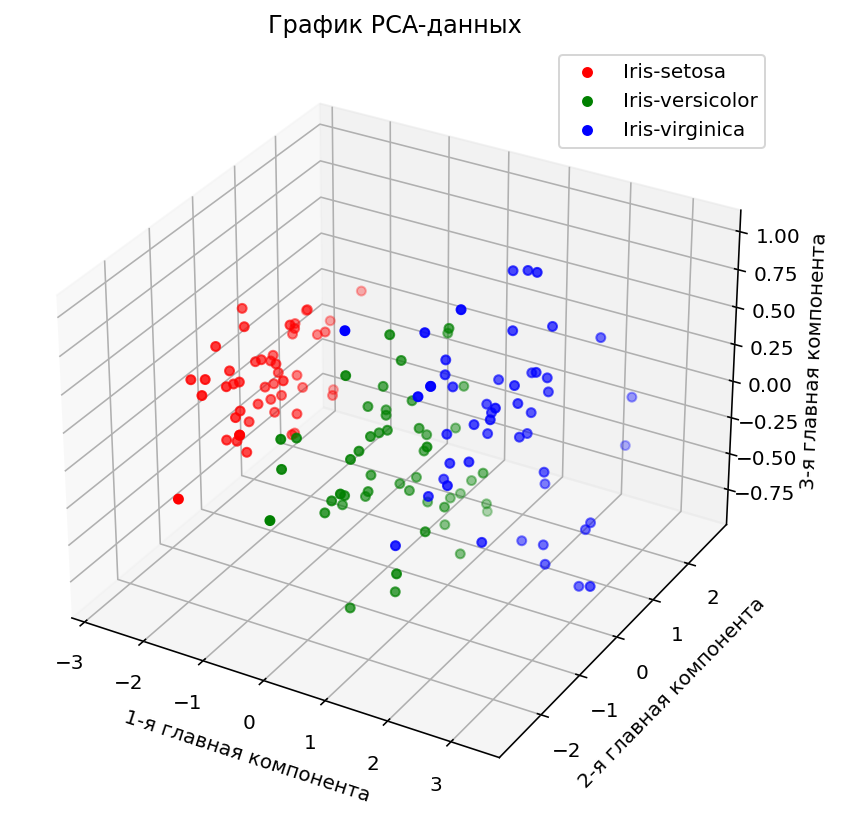

In [6]:
'''
iris
'''



iris_df = pd.read_csv('iris.data',
                      names=[
                          'Длина чашелистика', 'Ширина чашелистика',
                          'Длина лепестка', 'Ширина лепестка', 'Вид'
                      ])
analyze(iris_df, iris=True)

*** Исходные данные ***


Первые 5 строк таблицы:


,1-й признак,2-й признак,3-й признак,4-й признак,5-й признак,6-й признак,7-й признак,8-й признак,9-й признак,10-й признак,...,16-й признак,17-й признак,18-й признак,19-й признак,20-й признак,21-й признак,22-й признак,23-й признак,24-й признак,Класс
0,1,6,4,12,5,5,3,4,1,67,...,0,0,1,0,0,1,0,0,1,1
1,2,48,2,60,1,3,2,2,1,22,...,0,0,1,0,0,1,0,0,1,2
2,4,12,4,21,1,4,3,3,1,49,...,0,0,1,0,0,1,0,1,0,1
3,1,42,2,79,1,4,3,4,2,45,...,0,0,0,0,0,0,0,0,1,1
4,1,24,3,49,1,3,3,4,4,53,...,1,0,1,0,0,0,0,0,1,2



Выборочная матрица ковариаций:
[[ 1.58165265e+00 -1.09212312e+00  2.61796797e-01 -1.51876577e+00
   4.42857858e-01  1.61593594e-01  3.85245245e-02 -5.86236236e-02
  -4.26086086e-02  8.54812813e-01  4.15665666e-02  5.52162162e-02
  -6.44144144e-03  4.09329329e-02 -6.35535536e-03 -3.70550551e-02
   2.45935936e-02  4.47057057e-02 -1.26696697e-02 -4.43273273e-02
   7.36726727e-02 -8.70270270e-03 -2.04204204e-02  3.35235235e-02]
 [-1.09212312e+00  1.45415006e+02 -1.00814314e+00  2.12847815e+02
   9.08093093e-01  8.36084084e-01  1.26280280e-01  4.53418418e-01
   3.84957558e+00 -4.95699499e+00 -4.66991992e-01 -7.85995996e-02
  -1.04069069e-01  9.75163163e-01 -3.14725726e-01 -5.61863864e-01
   5.31522523e-01  3.50140140e-02  7.10480480e-02 -2.97934935e-01
  -4.10249249e-01 -7.79439439e-02 -8.74474474e-01  3.20430430e-01]
 [ 2.61796797e-01 -1.00814314e+00  1.17314815e+00 -1.84033534e+00
   6.68418418e-02  1.80900901e-01  3.23423423e-02  7.55505506e-02
  -6.11711712e-02  1.81224224e+00  9.32182

,1-я главная компонента,2-я главная компонента,3-я главная компонента,Класс
0,0.013239,-2.938552,0.794005,1
1,0.275404,0.919434,-2.403241,2
2,-2.183315,-1.905036,1.756690,1
3,1.508041,1.303072,0.918198,1
4,1.230629,-0.294542,1.968498,2



Выборочная матрица ковариаций:
[[ 2.52079886e+00  1.33715750e-15 -5.04990333e-16]
 [ 1.33715750e-15  2.12245039e+00 -1.01709321e-15]
 [-5.04990333e-16 -1.01709321e-15  1.85547030e+00]]



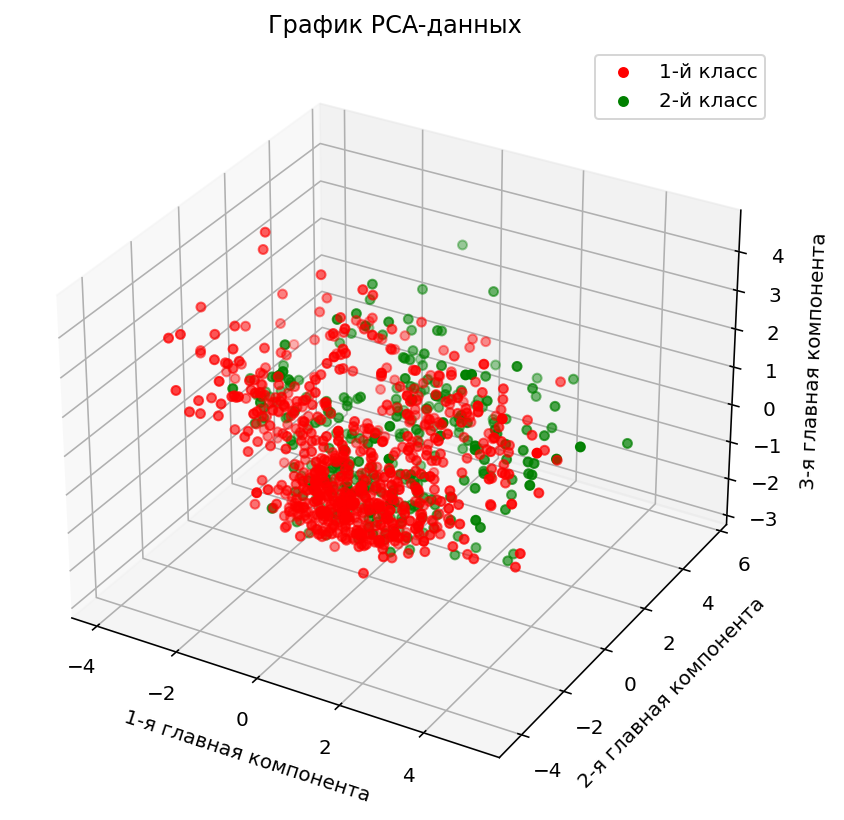

In [7]:
'''
german
'''



'''
Получение и считывание данных из файла в двумерный список int'ов
'''
def parse_file(filename):
    arr = []

    with open(filename) as file:
        for line in file:
            arr.append(list(map(int, line.strip().split())))

    return arr



arr = parse_file('german.data-numeric')
p = len(arr[0]) - 1
columns = [str(i + 1) + '-й признак' for i in range(p)]
columns.append('Класс')

german_df = pd.DataFrame(data=arr, columns=columns)
analyze(german_df)